# LOB-CNN v1

- 高频交易数据图像化建模与收益预测有效性分析

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import os
import time
from datetime import datetime
import glob

import utils as _U

In [18]:
# 中证A50成分股
# 信息来源：东方财富 20250324
code_list = [
    '688981sh', '603993sh', '603259sh', '601899sh', '601888sh', 
    '601816sh', '601766sh', '601668sh', '601600sh', '601318sh', 
    '601088sh', '601012sh', '600900sh', '600893sh', 
    '600887sh', '600660sh', '600585sh', '600519sh', '600436sh', 
    '600426sh', '600415sh', '600406sh', '600309sh', '600276sh', 
    '600176sh', '600036sh', '600031sh', '600030sh', '600028sh', 
    '600019sh', '600009sh', '300760sz', '300750sz', '300408sz', 
    '300124sz', '300122sz', '300015sz', '002714sz', '002594sz', 
    '002475sz', '002371sz', '002230sz', '002027sz', '000938sz', 
    '000792sz', '000725sz', '000333sz', '000063sz', '000002sz'
    ]  

### 磁盘取数 + 初步处理

In [ ]:
# 获取 ~/ 目录下所有 snap_stkhf202101_*.sas7bdat 文件
for year_month in ['202111', '202112']:
    for code in code_list:
        file_path = glob.glob(f'/mnt/sdb1/HF{year_month[:4]}/L2HF{year_month[2:]}_L2/snap_stkhf{year_month}_{code}.sas7bdat')
        if file_path:
            train_df = pd.read_sas(file_path[0], format='sas7bdat', encoding='utf-8')
            train_df.to_csv(f'rawdata_L2HF{year_month[2:]}_L2/{code}.csv', index=False)
            print(f'{code}.csv saved. Shape: {train_df.shape}')
        else:
            print(f'{code} not found')
# 600941sh 中国移动上市日期 2022-01-05，晚于2021年11月

In [20]:
level2_col_list = []
for l in range(1, 11):
    BidPr_col = f'BidPr{l}'
    BidVol_col = f'BidVol{l}'
    AskPr_col = f'AskPr{l}'
    AskVol_col = f'AskVol{l}'
    level2_col_list.extend([BidPr_col, BidVol_col, AskPr_col, AskVol_col])
    
used_cols = [
    'datetime', 'Exchflg', 'Code', 'Code_Mkt', 'Qdate', 'QTime', 'InstrumentStatus', 'Trdirec',
    'PrevClPr', 'OpPr', 'HiPr', 'LoPr', 'Tprice', 'Tvolume', 'Tsum', 'Tdeals', 'TVolume_accu', 'TSum_accu', 'Tdeals_accu',
    'TotBidVol', 'WghtAvgBidPr', 'TotAskVol', 'WghtAvgAskPr',
    'Absspread', 'Respread', 'Abseffspread', 'Reeffspread', 'Depth1', 'Depth2'
]
used_cols.extend(level2_col_list)

for year_month in ['202111', '202112']:
    for code in code_list:
        train_df = pd.read_csv(f'rawdata_L2HF{year_month[2:]}_L2/{code}.csv')

        # convert all df in dfs to datetime
        date = pd.to_datetime(train_df['Qdate'])
        time = pd.to_timedelta(train_df['QTime'], unit='s')
        train_df['datetime'] = date + time
        
        # select used cols
        train_df = train_df[used_cols]
        train_df = _U.trading_time_slice(train_df)
        train_df.to_csv(f'data_{year_month}/{code}.csv', index=False)
        print(f'{code}.csv saved. Shape: {train_df.shape}')

FileNotFoundError: [Errno 2] No such file or directory: 'rawdata_L2HF2111_L2/688981sh.csv'

### Analysis

In [36]:
df = pd.read_csv('datasets_49-stock_2d-train_3d-test/train_X.csv')

In [51]:
def calculate_relative_prices(df, code=None, bin_width=50):
    """
    计算 relative price to best bid price，并绘制柱状图
    :param df: 包含 BidPr1-BidPr10 和 AskPr1-AskPr10 的 DataFrame
    :param bin_width: 柱状图的 bin 宽度，默认 50
    :return: relative_prices (一维 NumPy 数组)
    """
    price_cols = [f'BidPr{i}' for i in range(1, 6)] + [f'AskPr{i}' for i in range(1, 6)]
    price_cols += [f'BidPr{i}_lag{t}' for i in range(1, 6) for t in range(1, 10)]
    price_cols += [f'AskPr{i}_lag{t}' for i in range(1, 6) for t in range(1, 10)]
    
    df_relative = df.copy()
    for col in price_cols:
        df_relative[col] = df[col] * 1e16
        # df[col] = df[col] * 10000
        # df_relative[col] = df[col] - df['BidPr1_lag9']

    # 展开为一维数组
    df_relative.dropna(inplace=True)
    relative_prices = df_relative[price_cols].values.flatten()
    
    return relative_prices


In [ ]:
# 计算 relative prices
relative_prices = calculate_relative_prices(df, code)

# 计算众数（mode）
from scipy.stats import mode
mode_value = mode(relative_prices, nan_policy='omit')
print(mode_value) 

# 计算统计信息
stats = {
    'max': np.max(relative_prices),
    'min': np.min(relative_prices),
    'mean': np.mean(relative_prices),
    'median': np.median(relative_prices),
    '2.5%': np.percentile(relative_prices, 2.5),
    '25%': np.percentile(relative_prices, 25),
    '75%': np.percentile(relative_prices, 75),
    '97.5%': np.percentile(relative_prices, 97.5),
    'std': np.std(relative_prices),
    'abs_mean': np.mean(np.abs(relative_prices)),
    'abs_median': np.median(np.abs(relative_prices)),
    'abs_25%': np.percentile(np.abs(relative_prices), 25),
    'abs_75%': np.percentile(np.abs(relative_prices), 75),
    'abs_95%': np.percentile(np.abs(relative_prices), 95)
}
summary_df = pd.DataFrame(stats, index=[0])
# summary_df.to_csv("relative_price_summary.csv", index=False)
summary_df

ModeResult(mode=0.0, count=235705)
ModeResult(mode=0.0, count=235705)


,max,min,mean,median,2.5%,25%,75%,97.5%,std,abs_mean,abs_median,abs_25%,abs_75%,abs_95%
0,2.980473e+14,-6.387258e+14,5.511969e+10,-1.110223,-7.035176e+13,-8.926977e+12,9.020748e+12,7.021063e+13,2.745003e+13,1.716921e+13,8.982932e+12,4.158319e+12,1.977960e+13,7.021063e+13


In [63]:
import pandas as pd

# Convert to Series
series = pd.Series(relative_prices)

# Compute value counts
top_modes = series.value_counts().nlargest(2)  # Get the top 2 modes

# Extract results
first_mode = top_modes.index[0]
second_mode = top_modes.index[1] if len(top_modes) > 1 else None  # Handle edge case

print(f"First mode: {first_mode}, Second mode: {second_mode}")


First mode: 0.0, Second mode: 2.220446049250313


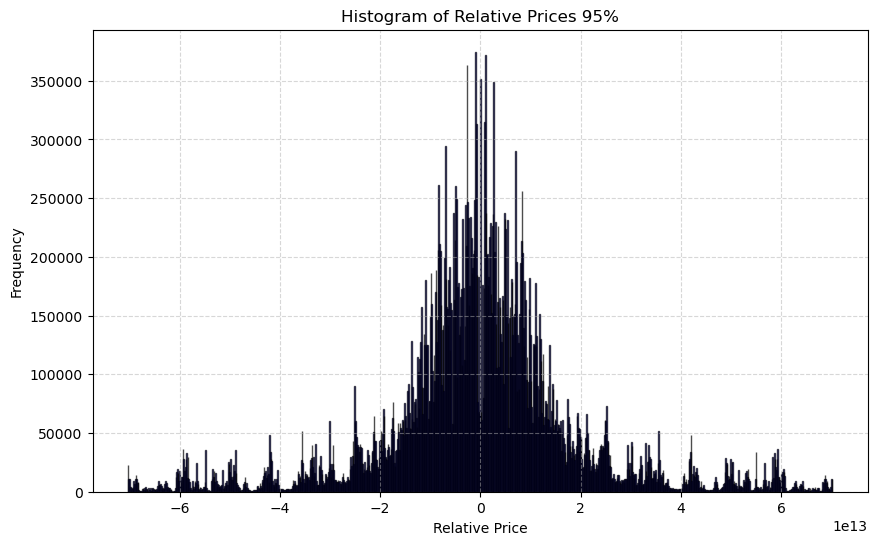

In [69]:
import matplotlib.pyplot as plt

rel_prices_95 = relative_prices[np.percentile(relative_prices, 2.5) < relative_prices]
rel_prices_95 = rel_prices_95[rel_prices_95 < np.percentile(relative_prices, 97.5)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(rel_prices_95, bins=1000, color='blue', alpha=0.7, edgecolor='black')

# Labels and title
plt.xlabel("Relative Price")
plt.ylabel("Frequency")
plt.title("Histogram of Relative Prices 95%")

# Show grid
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()


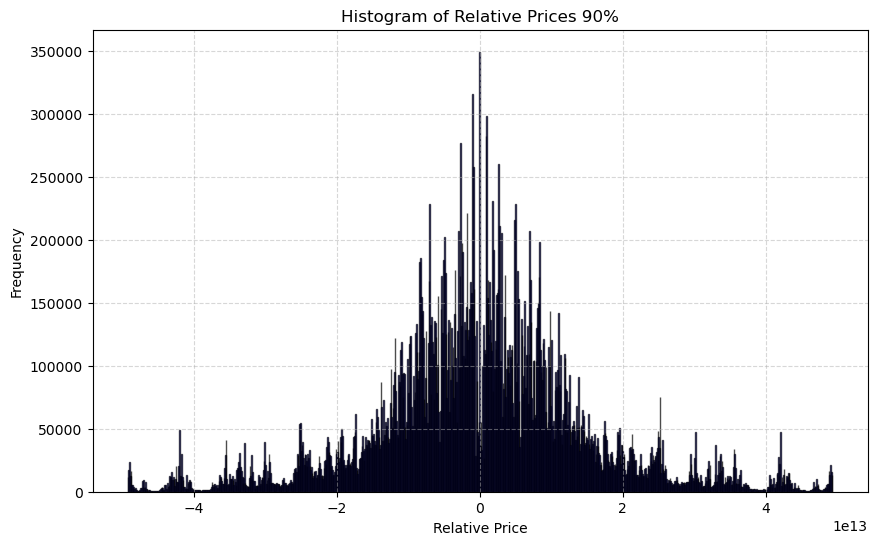

In [70]:
rel_prices_90 = relative_prices[np.percentile(relative_prices, 5) < relative_prices]
rel_prices_90 = rel_prices_90[rel_prices_90 < np.percentile(relative_prices, 95)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(rel_prices_90, bins=1000, color='blue', alpha=0.7, edgecolor='black')

# Labels and title
plt.xlabel("Relative Price")
plt.ylabel("Frequency")
plt.title("Histogram of Relative Prices 90%")

# Show grid
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()


In [57]:

# 计算相邻数值的最小间隔
relative_prices_sorted = np.sort(relative_prices)
diffs = np.diff(relative_prices_sorted)  # 计算相邻数据点的差值
print(len(diffs))
# 输出 0 的个数
print(f"0 的个数: {np.sum(diffs == 0)}")  # 44556165
print(f"最大的颗粒度: {np.max(diffs)}")

# 取接近中位数的部分
median_value = np.median(relative_prices_sorted)
median_index = np.searchsorted(relative_prices_sorted, median_value)

# 取中位数前后各1000个点的间隔
window_size = 1000  # 选取窗口大小
start = max(0, median_index - window_size // 2)
end = min(len(relative_prices_sorted) - 1, median_index + window_size // 2)
median_diffs = diffs[start:end]

print(f"中位数附近大于0的最小的颗粒度: {np.min(median_diffs[median_diffs > 0])}")
print(f"中位数附近颗粒度的均值: {np.mean(median_diffs[median_diffs > 0])}")
print(f"中位数附近颗粒度的标准差: {np.std(median_diffs[median_diffs > 0])}")


45892799
0 的个数: 44556165
最大的颗粒度: 102938338195981.0
中位数附近大于0的最小的颗粒度: 1.1102230246251568
中位数附近颗粒度的均值: 1.1102230246251568
中位数附近颗粒度的标准差: 0.0


### DataGen: Image + Label

In [ ]:
def calc_new_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    计算新的特征
    """
    df['mid_price'] = (df['BidPr1'] + df['AskPr1']) / 2
    
    pred_cnt = 5
    df['TWAP_mid'] = df['mid_price'].rolling(window=pred_cnt).mean()
    
    return df

In [ ]:
# imaging data
code_list = [
    '600176sh', 
]
folder_path = 'data_202111/'
record_cnt = 5
pred_cnt = 5
is_binary = True

image_list = []
label_list = []
for code in code_list:
    train_df = pd.read_csv(f'{folder_path}{code}.csv')
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    # train_df = train_df[train_df['datetime'] <= '2021-12-10 23:59:59']  # 测试集初步只取前10天
    train_df = calc_new_features(train_df)
    train_df.dropna(axis=0, inplace=True)
    train_df.reset_index(drop=True, inplace=True)
    for i in tqdm.tqdm(range(len(train_df) - (record_cnt + pred_cnt))):
        single_entry = _U.single_image(train_df.iloc[i:i + record_cnt + pred_cnt], record_cnt, pred_cnt, is_binary)
        image_list.append(single_entry[0])
        label_list.append(single_entry[1])
    print(f'{code}.csv loaded.')
    


100%|██████████| 104478/104478 [02:15<00:00, 773.67it/s]

600176sh.csv loaded.


- getting `df` directly without saving and loading

In [ ]:
image_df = pd.DataFrame({
    'image': image_list,
    'label': label_list
})

# Flatten images and create a new dataframe
flatten_data = []
for i in range(len(image_df)):
    flattened_image = image_df.loc[i, 'image'].flatten()
    label = image_df.loc[i, 'label']
    flatten_data.append(np.concatenate(([label], flattened_image)))  # Label in first column
    
columns = ['label'] + [f'pixel_{i}' for i in range(41 * 15)]
flatten_df = pd.DataFrame(flatten_data, columns=columns)
print(flatten_df.shape)

(104478, 616)


In [ ]:
train_df = flatten_df.copy()

- Save and downsample  `image_list` and `label_list`

In [ ]:
image_df = pd.DataFrame({
    'image': image_list,
    'label': label_list
})

sample_size = 10000
random_indices = np.random.choice(image_df.shape[0], sample_size, replace=False)
print(len(random_indices))
# Flatten images and create a new dataframe
flatten_data = []
for i in random_indices:
    flattened_image = image_df.loc[i, 'image'].flatten()
    label = image_df.loc[i, 'label']
    flatten_data.append(np.concatenate(([label], flattened_image)))  # Label in first column

columns = ['label'] + [f'pixel_{i}' for i in range(41 * 15)]
flatten_df = pd.DataFrame(flatten_data, columns=columns)
print(flatten_df.shape)

# Save to CSV
current_time = datetime.now().strftime('%Y%m%d_%H%M')
flatten_df.to_csv(f'image_dataset_{current_time}.csv', index=False)

# write a log in JSON for image_df
import json
log = {
    'original_data_folder_path': folder_path,
    'code_list': code_list,
    'record_cnt': record_cnt,
    'pred_cnt': pred_cnt,
    'ori_shape': image_df.shape,
    'sample_size': sample_size,
    'datetime': current_time
}
log_path = f'image_dataset_{current_time}.json'
with open(log_path, 'w') as f:
    json.dump(log, f, indent=4)
print(f'log saved to {log_path}')


10000
(10000, 616)
log saved to image_dataset_20250325_1447.json


- Load downsampled `image_df` and re-structure the np.array

In [ ]:
train_df = pd.read_csv('image_dataset_20250324_2212.csv')
print(train_df.shape)

# Prepare data for CNN (reshape 615 -> 41x15)
features = train_df.iloc[:, 1:].values
train_X_cnn = features.reshape(-1, 41, 15)  # Shape: (num_samples, 41, 15)

train_labels = train_df.iloc[:, 0].values

(50000, 616)


### Models

In [ ]:
train_df = pd.read_csv('image_dataset_20250324_2212.csv')
test_df = pd.read_csv('image_dataset_20250325_1447.csv')
print(train_df.shape, test_df.shape)

(50000, 616) (10000, 616)


In [ ]:
train_df.dropna(axis=0, inplace=True)
train_df.reset_index(drop=True, inplace=True)
test_df.dropna(axis=0, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(train_df.shape, test_df.shape)

(104478, 616) (37973, 616)


In [ ]:
# Preprare data
train_X_flat = train_df.drop(columns=['label']).values
train_X_cnn = train_X_flat.reshape(-1, 41, 15)  # Shape: (num_samples, 41, 15)
train_labels = train_df['label'].values 
train_labels = train_labels.astype(int)

test_X_flat = test_df.drop(columns=['label']).values
test_X_cnn = test_X_flat.reshape(-1, 41, 15)  # Shape: (num_samples, 41, 15)
test_labels = test_df['label'].values
test_labels = test_labels.astype(int)

print(f"Train label distribution: \n{train_df['label'].value_counts(normalize=True)}")
print(f"Test label distribution: \n{test_df['label'].value_counts(normalize=True)}")

Train label distribution: 
label
0.0    0.843632
1.0    0.156368
Name: proportion, dtype: float64
Test label distribution: 
label
0.0    32656
1.0     5317
Name: count, dtype: int64


In [ ]:
# randomly sample 10000 data from train_df and test_df
sample_size = 10000
random_indices_train = np.random.choice(train_df.shape[0], sample_size, replace=False)
random_indices_test = np.random.choice(test_df.shape[0], sample_size, replace=False)

train_X_flat = train_X_flat[random_indices_train]
test_X_flat = test_X_flat[random_indices_test]

train_labels = train_labels[random_indices_train]
test_labels = test_labels[random_indices_test]

In [ ]:
# traditional ML pipeline
dataset = {
    'train_X': train_X_flat,
    'train_y': train_labels,
    'test_X': test_X_flat,
    'test_y': test_labels
}
df_results = _U.traditional_ml_pipeline(dataset, balance=False, data_type='num')
print(df_results.sort_values('F1', ascending=False))

--- Logistic Regression (SGD) ---
Time elapsed:  1.7294812202453613 (s)
{'Model': 'Logistic Regression (SGD)', 'Accuracy': 0.8377, 'Precision': 0.32532051282051283, 'Recall': 0.14448398576512456, 'F1': 0.20009857072449483} 



/home/qbzhou21/.conda/envs/LOB-CNN/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--- Linear SVM ---
Time elapsed:  93.42627429962158 (s)
{'Model': 'Linear SVM', 'Accuracy': 0.8547, 'Precision': 0.38235294117647056, 'Recall': 0.05551601423487545, 'F1': 0.09695463020509633} 

--- XGBoost ---
Time elapsed:  269.83997535705566 (s)
{'Model': 'XGBoost', 'Accuracy': 0.8575, 'Precision': 0.4758454106280193, 'Recall': 0.1402135231316726, 'F1': 0.2166025288620121} 

--- MLP ---
Time elapsed:  2.337718963623047 (s)
{'Model': 'MLP', 'Accuracy': 0.8573, 'Precision': 0.36904761904761907, 'Recall': 0.02206405693950178, 'F1': 0.041638683680322364} 

Report saved to: reports/binary_Traditional_unbalanced_20250325_1644.csv
                       Model  Accuracy  Precision    Recall        F1
2                    XGBoost    0.8575   0.475845  0.140214  0.216603
0  Logistic Regression (SGD)    0.8377   0.325321  0.144484  0.200099
1                 Linear SVM    0.8547   0.382353  0.055516  0.096955
3                        MLP    0.8573   0.369048  0.022064  0.041639


### compare to original data

In [ ]:
# imaging data
code_list = [
    '600176sh', 
]
folder_path = 'data_202111/'
record_cnt = 5
pred_cnt = 5
is_binary = True

for code in code_list:
    train_df = pd.read_csv(f'{folder_path}{code}.csv')
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    # train_df = train_df[train_df['datetime'] <= '2021-12-10 23:59:59']  # 测试集初步只取前10天
    train_df = calc_new_features(train_df)
    train_df.dropna(axis=0, inplace=True)
    train_df.reset_index(drop=True, inplace=True)
    print(f'{code}.csv loaded.')

folder_path = 'data_202112/'
for code in code_list:
    test_df = pd.read_csv(f'{folder_path}{code}.csv')
    test_df['datetime'] = pd.to_datetime(test_df['datetime'])
    test_df = test_df[test_df['datetime'] <= '2021-12-10 23:59:59']  # 测试集初步只取前10天
    test_df = calc_new_features(test_df)
    test_df.dropna(axis=0, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    print(f'{code}.csv loaded.')
